# Boosting


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
  return x ** 2

def grad(x):
  return 2 * x

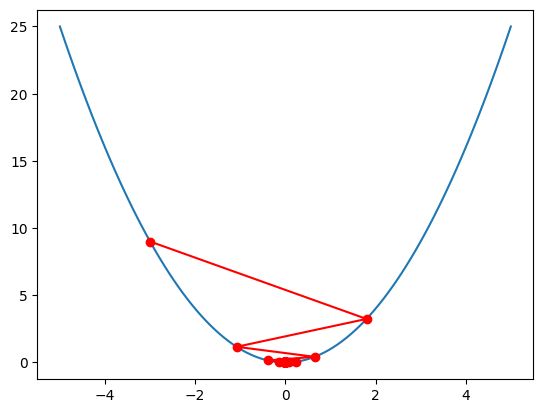

In [16]:
np.random.seed(123)
x = np.random.randint(-5, 5)
eta = 0.8
m = 10000
X = []
for _ in range(m):
  X.append(x)
  x = x - eta * grad(x)

x_ = np.linspace(-5, 5, 100)
y = f(x_)

plt.plot(x_, y)
plt.plot(X, list(map(f, X)), '-o', color='r')
plt.show()

In [20]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [21]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import numpy as np
import pandas as pd

Input: conjunto de entrenamiento $\{(x_i, y_i)\}_{i=1}^n$, función de pérdida diferenciable $L(y, F(x))$, número de iteraciones $M$

Algoritmo:

1. Inicializar el modelo con un valor constante:

$$F_0(x)=\arg \min_{\gamma}\sum_{i=1}^n L(y_i, \gamma)$$

2. For m=1 hasta $M$:
  1. Calcular los pseudo-residuos:
      $$r_{im}=-\bigg[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\bigg]$$
  2. Ajustar un modelo básico $h_m(x)$ a los residuales: $\{(x_i, r_{im})\}_{i=1}^n$
  3. Calcular el multiplicador $\gamma_m$:
      
      $$\gamma_m = \arg \min_{\gamma} \sum_{i=1}^n L(y_i, F_{m-1}(x_i)+\gamma h_m(x_i))$$
  4. Actualizar el output:
      $$F_m(x)=F_{m-1}(x)+\gamma_mh_m(x)$$

Output: $F_M(x)$


In [19]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth

        self.estimators = []
        self.residuals = []
        self.base_prediction = 0

    def fit(self, X, y):
        self.base_prediction = np.mean(y)
        self.residuals = y - self.base_prediction

        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, self.residuals)
            prediction = tree.predict(X)
            self.estimators.append(tree)
            self.residuals -= self.learning_rate * prediction

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for estimator in self.estimators:
            y_pred += self.learning_rate * estimator.predict(X)
        return y_pred + self.base_prediction

In [22]:
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_classes=2)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## GradientBoosting

`learning_rate`

`max_depth`

`n_estimators`

`min_samples_split`

`min_samples_leaf`

In [24]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
accuracy_score(y_pred_gbc, y_test)

0.94

In [26]:
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 4, 5, 6],
              'n_estimators': [100, 150, 200],
              'min_samples_split': [3, 5, 7, 9]}
gs_gbc = GridSearchCV(GradientBoostingClassifier(),
                      param_grid=param_grid,
                      cv=3,
                      scoring='accuracy',
                      verbose=2)
gs_gbc.fit(X_train, y_train)
preds = gs_gbc.predict(X_test)
accuracy_score(y_test, preds)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=100; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=150; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=150; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=150; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_split=3, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, min_s

0.93

## HistGradientBoosting

`learning_rate`

`max_leaf_nodes`

`max_depth`

`min_samples_leaf`

In [25]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train)
y_pred_hgbc = hgbc.predict(X_test)
accuracy_score(y_pred_hgbc, y_test)

0.95

## XGBoosting

`eta`: learning rate

`gamma`: min_split_loss

`max_depth`: profundidad

`lambda`: l2 regularization

`alpha`: l1 regularization


In [ ]:
xbc = XGBClassifier()
xbc.fit(X_train, y_train)
y_pred_xbc = xbc.predict(X_test)
accuracy_score(y_pred_xbc, y_test)

0.96

## LightGBM

`num_leaves`

`max_depth`

`n_estimators`

`learning_rate`

`reg_lambda`

`reg_alpha`

In [ ]:
lgbc = LGBMClassifier()
lgbc.fit(X_train, y_train)
y_pred_lgbc = lgbc.predict(X_test)
accuracy_score(y_pred_lgbc, y_test)

0.955

## CatBoost

`learning_rate`

`max_depth`


In [ ]:
cbc = CatBoostClassifier()
cbc.fit(X_train, y_train, verbose=False)
y_pred_cbc = cbc.predict(X_test)
accuracy_score(y_pred_cbc, y_test)

0.985

In [ ]:
!pip install wooldridge
import wooldridge as wd
hprice = wd.data('hprice1')

In [ ]:
hprice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     88 non-null     float64
 1   assess    88 non-null     float64
 2   bdrms     88 non-null     int64  
 3   lotsize   88 non-null     float64
 4   sqrft     88 non-null     int64  
 5   colonial  88 non-null     int64  
 6   lprice    88 non-null     float64
 7   lassess   88 non-null     float64
 8   llotsize  88 non-null     float64
 9   lsqrft    88 non-null     float64
dtypes: float64(7), int64(3)
memory usage: 7.0 KB
